cDCGAN Mnist Simple

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive, files
import itertools

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

Generator for 32x32 image

In [0]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        d = 128 # latent
        self.deconv1s = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1s_bn = nn.BatchNorm2d(d*2)
        self.deconv1t = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1t_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input_, label):
        x = F.relu(self.deconv1s_bn(self.deconv1s(input_)))
        y = F.relu(self.deconv1t_bn(self.deconv1t(label)))
        x = torch.cat([x, y], 1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))

        return x

Discriminator for 32x32 image

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(Discriminator, self).__init__()
        d = 64 # Num of dimension.

        self.conv1_1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv1_2 = nn.Conv2d(10, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*4)
        self.conv3 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*8)
        self.conv4 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = torch.sigmoid(self.conv4(x))
        return x

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Train data sets 

In [0]:
# Hyper parameters
img_size = 32
batch_size = 128

In [0]:
data_transforms = transforms.Compose(
    [
     transforms.Resize(img_size),     
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)]
)

train_datasets = datasets.MNIST(root="./datasets",
                                        train=True, download=True,
                                        transform=data_transforms)

loaders = torch.utils.data.DataLoader(train_datasets, 
                                      batch_size=batch_size,
                                      shuffle=True)

In [682]:
# Exercise 1
iter(loaders).next()

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

In [0]:
def im_show(image):
    print(image.shape)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    im = image.detach().numpy()
    im = im.transpose(1, 2, 0) # c h w -> h w c
    im = std * im + mean
    plt.imshow(im)

In [683]:
# Exercise 2
iter(loaders).next()[0].shape

torch.Size([128, 1, 32, 32])

torch.Size([1, 32, 32])


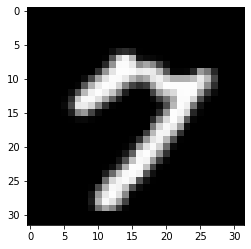

In [686]:
# Exercise 3
im_show(iter(loaders).next()[0][0])

In [0]:
def create_noise(batch_size):
    z = torch.randn((batch_size, 100, 1, 1)) # 正規化 -3.0 to -3.0
    return z.cuda()

In [0]:
def create_label(batch_size):
    label = torch.zeros(batch_size, 10)
    label.scatter_(1, label.type(torch.LongTensor), 1)
    label = label.view(-1, 10, 1, 1).cuda()
    return label.cuda()

In [0]:
def make_log(epoch, i, loss_info):
    log  = "epoch: " + str(epoch)
    log += " iter: " + str(i)
    log += " loss: " + str(loss_info)
    return log

In [687]:
# Exercise 4
epoch = 2
i = 15
loss_info = "0.0001"
make_log(epoch, i, loss_info)

'epoch: 2 iter: 15 loss: 0.0001'

In [0]:
def show_train_history(data):
    x = range(len(data['loss_D']))

    y1 = data['loss_D']
    y2 = data['loss_G']

    plt.plot(x, y1, label='loss_D')
    plt.plot(x, y2, label='loss_G')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.ylim(0, 10)

    plt.grid(True)
    plt.legend(loc=4)
    plt.tight_layout()
    plt.show()

In [0]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    G.eval()
    test_images = G(fixed_z_, fixed_y_label_)
    G.train()

    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [0]:
# target_real = target_fake = pred = fake = None # For debug
# def train_batch(batch, z):
#     pass

Settings

In [0]:
# Hyper parameters
learning_rate = 0.0002

In [0]:
# Train history
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

In [0]:
# Create filled data for discriminator.
label_fills = torch.zeros(10, 10, img_size, img_size)
ones = torch.ones(img_size, img_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.cuda()

In [691]:
# Exercise 5
label_fills[1]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [0]:
# Create one-hot vector
label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).cuda()

In [692]:
# Exercise 6
label_1hots.view(10,10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [0]:
# Settings: Auto grad parameters for targets. 
#  Discriminatorの教師ラベル生成と自動微分化
t_real = Variable(torch.ones(batch_size)).cuda()
t_fake = Variable(torch.zeros(batch_size)).cuda()

Instance

In [0]:
# Criteiron: Binary Cross Entropy loss
BCE_loss = torch.nn.BCELoss()

In [0]:
# Instance
G = Generator().cuda()
D = Discriminator().cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

In [0]:
# Optimizer
optimizer_G = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [0]:
# Train log.
loss_list={}
loss_list['loss_G']=[]
loss_list['loss_D']=[]

Train

In [0]:
# Hyper parameters
epochs = 10
epoch_from = 1 # 継続の場合は、途中の番号を設定

In [0]:
# Train loop
for epoch in range(epoch_from, epochs + 1):

    print('epoch', epoch)
    
    if epoch == 5:
        optimizer_D.param_groups[0]['lr'] = learning_rate/2
    elif epoch==7:
        optimizer_D.param_groups[0]['lr'] = learning_rate/4
    elif epoch==9:
        optimizer_D.param_groups[0]['lr'] = learning_rate/8

    for i, (x_batch, t_batch) in enumerate(loaders):

        # 取得したミニバッチのサイズ
        N = len(x_batch)

        label_1hot = label_1hots[t_batch]
        label_fill = label_fills[t_batch]

        # Genarator loss
        z = create_noise(N)
        fake = G(z, label_1hot)
        pred = D(fake, label_fill).squeeze()

        loss_G = BCE_loss(pred, t_real[0:N])
        loss_list['loss_G'].append(loss_G)

        # Lock discriminator (Not to need on PyTorch.)
        """
        for param in D.parameters():
            param.requires_grad = False
        """

        # Update Generator
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()


        # Unlock discriminator (Not to need on PyTorch.)
        """
        for param in D.parameters():
            param.requires_grad = True
        """

        # Discriminator loss

        # Real loss
        real = Variable(x_batch).cuda()
        pred = D(real, label_fill).squeeze()
        loss_D_real = BCE_loss(pred, t_real[0:N])

        # Fake loss
        z = create_noise(N)
        fake = G(z, label_1hot)
        pred = D(fake.detach(), label_fill).squeeze()
        loss_D_fake = BCE_loss(pred, t_fake[0:N])

        # Total loss
        loss_D = (loss_D_real + loss_D_fake) * 0.5
        loss_list['loss_D'].append(loss_D)

        # Update Discriminator
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        if i%100 == 0:
            print ('G:%.4f D: %.4f' %(loss_G,loss_D))

    epoch_from += 1

In [0]:
# Labels for test.
t_test = torch.zeros(100, dtype=int)

n = 0
for i in range(100):
    t_test[i] = n
    if (i+1)%10 == 0:
        n += 1

In [694]:
# Exercise 7
t_test

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

In [0]:
def test():
    G.eval()
    z = create_noise(100)
    label_1hot = label_1hots[t_test]
    fake = G(z, label_1hot).cpu()
    return fake.cpu()

torch.Size([1, 32, 32])


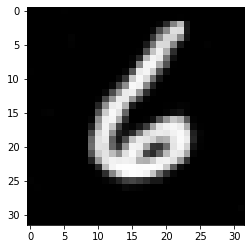

In [697]:
# Test
fake = test() # n:0-99
im_show(fake[60])

In [0]:
def im_layout(images):
    print(images.shape)

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    im = images.detach().numpy()
    im = im.transpose(0, 2, 3, 1) # c h w -> h w c
    im = std * im + mean

    plt.figure(figsize=(10,10))

    row = 10
    col = 10
    n = 0
    while n < row * col:
        n += 1
        plt.subplot(row, col, n)
        plt.imshow(im[n-1])
        plt.axis('off')

torch.Size([100, 1, 32, 32])


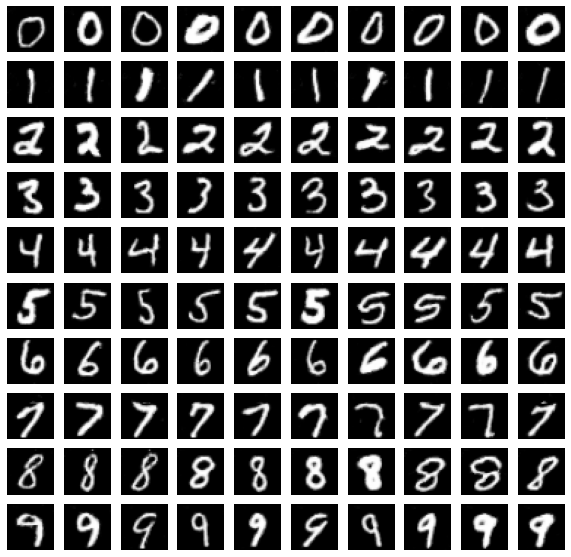

In [676]:
im_layout(test())

In [0]:
def load_data():
    G.load_state_dict(torch.load('cDCGAN_G.pkl'))
    D.load_state_dict(torch.load('cDCGAN_D.pkl'))
    optimizer_G.load_state_dict(torch.load('cDCGAN_optimizer_G.pkl'))
    optimizer_D.load_state_dict(torch.load('cDCGAN_optimizer_D.pkl'))
    print("Loaded.")

In [0]:
# load_data()

In [0]:
def save_model():
    torch.save(G.state_dict(), 'cDCGAN_G.pkl')
    torch.save(D.state_dict(), 'cDCGAN_D.pkl')
    torch.save(optimizer_G.state_dict(), 'cDCGAN_optimizer_G.pkl')
    torch.save(optimizer_D.state_dict(), 'cDCGAN_optimizer_D.pkl')

In [0]:
save_model()

In [0]:
files.download('cDCGAN_G.pkl')
files.download('cDCGAN_D.pkl')
files.download('cDCGAN_optimizer_G.pkl')
files.download('cDCGAN_optimizer_D.pkl')